In [1]:
import yfinance as yf
from pathlib import Path



assets = {"SPX":"^GSPC","GOLD":"GC=F","BTC":"BTC-USD"}
start, end = "2022-01-01","2025-01-01"

# Ensure the raw data directory exists
raw_dir = Path('data/raw')
raw_dir.mkdir(parents=True, exist_ok=True)

for name, ticker in assets.items():
    try:
        print(f"Downloading {name} ({ticker})...")
        df = yf.download(ticker, start=start, end=end)
        df['Close'].to_csv(raw_dir / f"{name}.csv")
        print(f"Saved raw data for {name} to {raw_dir / (name + '.csv')}")
    except Exception as e:
        print(f"Error downloading {name}: {e}")

/var/folders/sr/7d6q0qpj6d38ppqlpgw6vtxh0000gn/T/ipykernel_4743/2555723900.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/sr/7d6q0qpj6d38ppqlpgw6vtxh0000gn/T/ipykernel_4743/2555723900.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)


Saved raw data for SPX to data/raw/SPX.csv


[*********************100%***********************]  1 of 1 completed
/var/folders/sr/7d6q0qpj6d38ppqlpgw6vtxh0000gn/T/ipykernel_4743/2555723900.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)


Saved raw data for GOLD to data/raw/GOLD.csv


[*********************100%***********************]  1 of 1 completed

Saved raw data for BTC to data/raw/BTC.csv


In [2]:
import os
print("Current working dir:", os.getcwd())

# And list whatever’s in data/raw right now:
print("data/raw contains:", os.listdir("data/raw"))

Current working dir: /Users/jivenchana/PycharmProjects/cyber-fractal-entanglement/data
data/raw contains: ['BTC.csv', 'GOLD.csv', 'SPX.csv']


SPX     0
GOLD    0
BTC     0
dtype: int64
Duplicates: 0
Freq: B
SPX     1.267657
GOLD    1.220786
BTC     1.168370
dtype: float64 SPX     2.349120
GOLD    2.291474
BTC     2.398653
dtype: float64
Zero-var assets: SPX     False
GOLD    False
BTC     False
dtype: bool
Extreme FD outliers:
 SPX     0
GOLD    0
BTC     0
dtype: int64
          mean       std      skew      kurt
SPX   1.776826  0.185840  0.054232 -0.065849
GOLD  1.771429  0.221402 -0.072781 -0.388327
BTC   1.812730  0.247776 -0.103711 -0.534049
           SPX      GOLD       BTC
SPX   1.000000 -0.135887  0.195673
GOLD -0.135887  1.000000  0.083052
BTC   0.195673  0.083052  1.000000
SPX ADF p-value: 1.4180330405876239e-05
GOLD ADF p-value: 2.2125069366832027e-15
BTC ADF p-value: 1.3404580196551555e-22


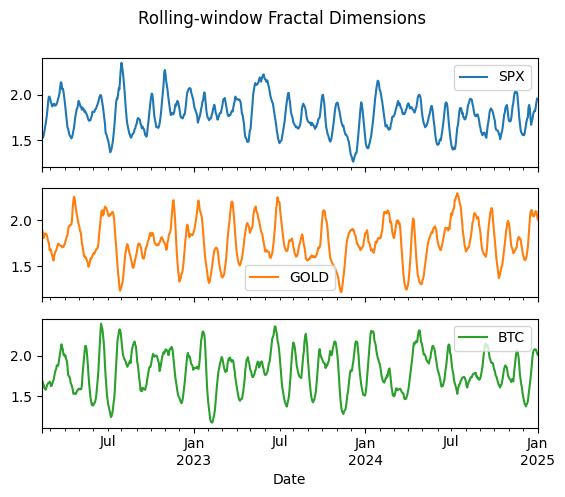

In [5]:
import pandas as pd
df_fd = pd.read_csv("processed/fractals.csv", index_col=0, parse_dates=True)
print(df_fd.isna().sum())
print("Duplicates:", df_fd.index.duplicated().sum())
print("Freq:", df_fd.index.inferred_freq)
print(df_fd.min(), df_fd.max())
print("Zero-var assets:", (df_fd.std()==0))

from scipy.stats import zscore
z = df_fd.apply(zscore)
print("Extreme FD outliers:\n", (z.abs()>5).sum())

stats = pd.DataFrame({
    "mean":   df_fd.mean(),
    "std":    df_fd.std(),
    "skew":   df_fd.skew(),
    "kurt":   df_fd.kurtosis()
})
print(stats)

print(df_fd.corr())
df_fd.plot(subplots=True, title="Rolling-window Fractal Dimensions")

from statsmodels.tsa.stattools import adfuller
for col in df_fd:
    p = adfuller(df_fd[col].dropna())[1]
    print(col, "ADF p-value:", p)
